# **PyTorch Implementation of Neural Networks**
In this week's graded assignment, you will implement a neural network that will perform binary classification on a set of images (ie. is or is not).

You are to only write/modify the code in between consecutive `# <START>` and `# <END>` comments. DO NOT modify other parts of the notebook, your assignments will not be graded otherwise.

```python
"Don't modify any code here"

# <START>
"YOUR CODE GOES HERE!"
# <END>

"Don't modify any code here"
```
## **Before you begin**
Before you start with the assignment, you will have to upload the images that you will classify to your Google Drive.  
You will be able to find the compressed folder named **"pizza_vs_not"** on both the GitHub repo and the Week 1 MS Teams channel.  
Download the file, unzip it, and then upload it to your Drive.

### **Make sure to upload to the same account that you are using on Colab, otherwise you won't be able to access the files**


## **Mounting Google Drive**
First, we need to import the dataset of images from your Google Drive. To do so, **run the below cell**. This will mount your Drive to the running Colab instance. Then, you will be able to access all your Google Drive data in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## **Import the Libraries**

Run the cell below to import all the necessary libraries for building the neural network using PyTorch.  
You will primarily use the **`nn` module** of the **PyTorch** library for building the neural network.

In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import matplotlib.image as mpimg
%matplotlib inline

## **Importing the Dataset**

We now need to import the dataset from the Google Drive. Below given is a function named `getdata`, which takes the path of the folder from which data is to be imported as its argument.

You are required to give in the path of the folder in which the images of `pizza` and `not_pizza` are saved in your Google Drive. Locate the path using the Colab File Explorer (the file icon in the sidebar).

The `getdata` function reads each image stored at the given path and converts and stores it as a PyTorch Tensor.

_Note: This cell may take a while to finish running_
<details>
  <summary>Hint</summary>
  The Google Drive was mounted to the location "/content/drive", containing the folder "My Drive", which corresponds to your actual Google Drive.
</details>

In [19]:
def getdata(path):
  data = torch.tensor([])
  file_list = os.listdir(path)
  for file_name in file_list[:350]:
    image_path = os.path.join(path, file_name)
    image = mpimg.imread(image_path)
    imageData = torch.from_numpy(image).long()
    data = torch.cat((data, imageData.unsqueeze(0)), dim=0)
  return data

# <START>
# pizza_path = 'C:\Users\raush\Desktop\temp\Deep Learning\LS\pizza_vs_not\pizza_vs_not\pizza'
pizza_path = r'C:\Users\raush\Desktop\temp\Deep Learning\LS\pizza_vs_not\pizza_vs_not\pizza'
not_pizza_path = r'C:\Users\raush\Desktop\temp\Deep Learning\LS\pizza_vs_not\pizza_vs_not\not_pizza'

# not_pizza_path = 'C:\Users\raush\Desktop\temp\Deep Learning\LS\pizza_vs_not\pizza_vs_not\not_pizza'
# <END>

not_pizza_data = getdata(not_pizza_path)
pizza_data = getdata(pizza_path)

Using the next cell, you can preview the images you've just loaded

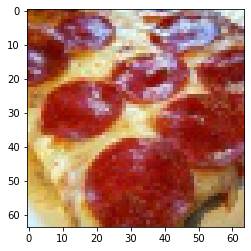

In [20]:
# Change values of index, data
# <START>
index =3 # 0 to 349
data = pizza_data # pizza_data (or) not_pizza_data
# <END>

plt.imshow(data[index].int())

## **Preprocessing the dataset**

Before we begin working with the neural network, we need to make sure our data (in this case, $64\times64$ RGB images) is in a format that neural networks can work with.

First, we create a `train_data` collection of images for training the neural network, and another collection `test_data` that will then be used to check the accuracy of the trained neural network. We do this by taking slices of the total data and concatenating them.  

In [21]:
train_data = torch.cat((pizza_data[:300], not_pizza_data[:200]), dim = 0)
test_data = torch.cat((pizza_data[300:350], not_pizza_data[200:250]), dim = 0)
print(train_data.shape)

torch.Size([500, 64, 64, 3])


Each image is still stored as a $64\times64\times3$ tensor ie. a $64\times64$ array of 3 numbers - the RGB values of the pixel, taking values between **0 to 255**.  
You need to flatten the images in both datasets to make *reshaped* data, and normalise them to get the *final* data we will use to train and test the model.

<details>
  <summary>Hint</summary>
  Use the reshape command to flatten the dataset and then normalise the flattened dataset (ie. make sure all the values lie between 0 and 1).
</details>

In [29]:
# test
# test_data.size(0)
# test_data.view(test_data.size(0), -1).size()
test_data.permute(0, 3, 1, 2).size()

torch.Size([100, 3, 64, 64])

In [30]:
# <START>


# Flatten and normalize the train_data
train_data_flattened = train_data.view(train_data.size(0), -1)
final_train_data = train_data_flattened.float() / 255.0

# Flatten and normalize the test_data
test_data_flattened = test_data.view(test_data.size(0), -1)
final_test_data = test_data_flattened.float() / 255.0

print(final_train_data.shape, final_test_data.shape)

# <END>

print(final_train_data.shape, final_test_data.shape)

torch.Size([500, 12288]) torch.Size([100, 12288])
torch.Size([500, 12288]) torch.Size([100, 12288])


Now that you have made two datasets, you need to make their corresponding `labels` Tensors, which store the true output for each image (whether or not it is a pizza).

In the `labels` Tensor, use **`1`** for images that belong to `pizza` and **`0`** for `not_pizza`. (Try to use the concatenate function instead of simply using *for* loops for generating the `labels` Tensor !!)

**Remember** to ensure that both `train_labels` and `test_labels` are 2D tensors of appropriate dimensions. Otherwise, it can cause issues ahead.

In [34]:
# <START>

num_pizza_train = train_data[:300].size(0)
num_not_pizza_train = train_data[300:].size(0)

train_labels = torch.cat((torch.ones(num_pizza_train), torch.zeros(num_not_pizza_train))).unsqueeze(1)

# Create labels for the test_data
num_pizza_test = test_data[:50].size(0)
num_not_pizza_test = test_data[50:].size(0)

test_labels = torch.cat((torch.ones(num_pizza_test), torch.zeros(num_not_pizza_test))).unsqueeze(1)


# <END>

print(train_labels.shape, test_labels.shape)

torch.Size([500, 1]) torch.Size([100, 1])


##**Building the Neural Network**

Now, we will start making the actual neural network.

First, initialise the hyperparameters of the neural network.  
Here, we are going to make a 3 layer neural network (i.e., 1 input layer, 2 hidden layers and 1 output layer). The first hidden layer will have 10 nodes, while the second will have 12.   
Enter the number of input parameters, number of nodes of each hidden layer and the number of output parameters.

In [37]:
# test
final_train_data.size(1) 

12288

In [35]:
# <START>

D_in = final_train_data.size(1)  # Number of input parameters
H1 = 10  # Number of nodes in the first hidden layer
H2 = 12  # Number of nodes in the second hidden layer
D_out = 1  # Number of output parameters


# <END>

Now you will make the actual model. The Model includes the use of `Linear` function at each layer, alongside non-linear activation functions.

We are going to use `ReLU` functions as activation functions for the input and the first hidden layer and `Sigmoid` function for the final output, as we want an output between 0 and 1.

(Hint: `Linear`, `ReLU` and `Sigmoid` functions are a part of the `nn` module of the **PyTorch** library)

In [38]:

model = torch.nn.Sequential(
    # Do not hard-code any values, use the variables from the previous cell
    # <START>
    nn.Linear(D_in, H1),  # Input layer
    nn.ReLU(),           # Activation function for the input layer

    nn.Linear(H1, H2),   # First hidden layer
    nn.ReLU(),           # Activation function for the first hidden layer

    nn.Linear(H2, D_out), # Output layer
    nn.Sigmoid()          # Activation function for the output layer
    # <END>

)


In [39]:
print(model)

Sequential(
  (0): Linear(in_features=12288, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=1, bias=True)
  (5): Sigmoid()
)


In [40]:
model(final_train_data[0]) #To check if the model works

tensor([0.5407], grad_fn=<SigmoidBackward0>)

After making the model, we defined the `loss_fn` , i.e., the loss function as the Binary Cross Entropy Loss.

Here, you will implement gradient descent.

The `learning_rate` is the step size which the neural network takes when it updates the parameters of the network. (Try to explore various values of step size. Values similar to 0.005 are usually suitable). Also play around with the number of `iterations` the gradient descent algorithm needs to take.

**Follow the steps given as per the comments.**

*Note: When you run the code, it could take about 5 minutes for the network to finish training.*

In [42]:
import torch.optim as optim
loss_fn = nn.BCELoss()

# <START>

learning_rate = 0.005
iterations = 10000
# Create an optimizer for gradient descent
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for t in range(iterations):

    # call the model on the dataset
    y_pred =model(final_train_data)

    #calculate the loss
    loss =loss_fn(y_pred, train_labels)

    if t%1000 == 1:
        print(loss)

    #calculate the gradients (dont forget to reset the gradients before you begin)
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()

    # Update the values of the parameters
    optimizer.step()


    # update the values of the parameters
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

        # Reset the gradients
        model.zero_grad()
        

# <END>

torch.save(model, 'model_best.pt')

tensor(0.6797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0699, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0130, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0042, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0022, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0014, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0010, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0006, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0005, grad_fn=<BinaryCrossEntropyBackward0>)


## **Checking the Results**
Now that we have used the training set to train the network, we shall use the test set to check how the neural network performs with new inputs.

According to the neural network, index = 88 is not a pizza


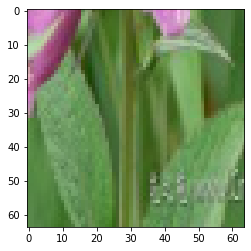

In [45]:
# Change values of index
# <START>
index = 88 #0 to 99
# <END>

plt.imshow(test_data[index].int())
print (f'According to the neural network, index = {index} is {"a pizza" if model(final_test_data[index]) > 0.5 else "not a pizza"}' )

To quantize how accurately the neural network is able to classify images, we have defined a helper `predict` function that takes a dataset and returns the fraction of times the neural network correctly classified the image.  

Complete the function such that it prints the correct accuracy of its predictions.

In [49]:
def predict(model, data, labels):

    probabilities = model(data)

    # <START>

    # generate the predictions tensor using the probabilities variable, which indicates the prediction made by the model for the given data using 0 and 1

    predictions =(probabilities >= 0.5).float()

    # <END>

    print("Accuracy: "  + str(torch.sum((predictions == labels)).item()/predictions.shape[0]))

**Run** the cell below to find out the accuracy of your model for the training and test datasets.

In [50]:
predict(model, final_train_data, train_labels)
predict(model,final_test_data,test_labels)
print("Done!")

Accuracy: 1.0
Accuracy: 0.8
Done!


## **Extra Content (Optional)**
##### **These are extra exercises you can try after submitting the assignment, for you to try on your own. Feel free to approach us with any doubts, but DO NOT make these changes to the notebook before you submit**
- Try varying things like the number and size of the hidden layers, and seeing how that affects the accuracy of the network.
- Along with `pizza` and `not_pizza`, you should see another folder `other_dishes` in the dataset. Try using it in place of `not_pizza`. What changes do you see? Why do you think this happens?